In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
from quaternion import Quaternion

In [243]:
def scale_value(value, scale, x):
    return round((abs(value) / x) * scale) 

def scale_roll(roll, scale):
    return scale_value(roll, scale, 180)

def scale_pitch(pitch, scale):
    return scale_value(pitch, scale, 90)
   
stimuli = []   
 
scale_type = {
    "gesture_pitch_number": 100,
    "gesture_pitch_greyscale": 49,
    "gesture_roll_number": 100,
    "gesture_roll_greyscale": 49,
    "slider_number": 1,
    "slider_greyscale": 1,
}

euler_type = {
    "gesture_pitch_number": "XYZ",
    "gesture_pitch_greyscale": "XYZ",
    "gesture_roll_number": "XYZ",
    "gesture_roll_greyscale": "XYZ",
    "slider_number": "XYZ",
    "slider_greyscale": "XYZ",
}

with open('experiment_data/experiment_data_33.json', 'r') as file:
    data = json.load(file)

    if data:
        for experiment in data["completedExperiments"]:
            experiment_type = experiment.get("experimentType")
            for stimulus in experiment["successfulStimuli"]:
                sensor_reading = stimulus.get("sensorReading", {})
                quaternion = Quaternion(
                    sensor_reading.get("w"),
                    sensor_reading.get("x"),
                    sensor_reading.get("y"),
                    sensor_reading.get("z")
                )
                if None not in quaternion:
                    yaw, pitch, roll = quaternion.euler_angles(euler_type[experiment_type])
                    
                    pitch_deg = math.degrees(pitch)
                    roll_deg = math.degrees(roll)
                    
                    sensor_reading["roll"] = roll_deg
                    sensor_reading["pitch"] = pitch_deg

                    pitch_scaled = scale_pitch(pitch_deg, scale_type[experiment_type])
                    roll_scaled = scale_roll(roll_deg, scale_type[experiment_type])
                    truth_value = stimulus.get("truth")

                    stimulus["pitch"] = pitch_deg
                    stimulus["pitch_truth"] = pitch_scaled
                    stimulus["pitch_truth_diff"] = abs(truth_value - pitch_scaled)
                    stimulus["roll"] = roll_deg
                    stimulus["roll_truth"] = roll_scaled
                    stimulus["roll_truth_diff"] = abs(truth_value - roll_scaled)
                    stimulus["experiment_type"] = experiment_type
                    
                    stimuli.append(stimulus)

df = pd.DataFrame(data=stimuli)

In [236]:
df[df["experiment_type"] == "gesture_pitch_greyscale"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
100,26,0.0,"{'x': 0.178406, 'y': 0.820251, 'duration': 190...",1,device,17.214153,9,17,-115.365862,31,5,gesture_pitch_greyscale
101,1,0.0,"{'y': 0.78717, 'stability': 'Stable', 'activit...",2,device,23.968858,13,12,-111.167054,30,29,gesture_pitch_greyscale
102,21,0.0,"{'duration': 186, 'activity_confidence': 94, '...",3,device,0.990010,1,20,-105.212109,29,8,gesture_pitch_greyscale
103,6,0.0,"{'stability': 'Stable', 'w': 0.125793, 'z': 0....",4,device,26.130476,14,8,-107.662070,29,23,gesture_pitch_greyscale
104,5,0.0,"{'stability': 'Stable', 'w': 0.0199585, 'activ...",5,device,1.223608,1,4,-105.263292,29,24,gesture_pitch_greyscale
105,25,0.0,"{'timestamp': 1719572724, 'stability': 'Stable...",6,device,2.880000,2,23,-106.009309,29,4,gesture_pitch_greyscale
106,15,0.0,"{'duration': 151, 'timestamp': 1719572731, 'w'...",7,device,32.337367,18,3,-114.349917,31,16,gesture_pitch_greyscale
107,2,0.0,"{'y': 0.823547, 'activity_confidence': 97, 'w'...",8,device,19.227800,10,8,-114.546962,31,29,gesture_pitch_greyscale
108,21,0.0,"{'activity_confidence': 97, 'stability': 'Stab...",9,device,1.452699,1,20,-108.819862,30,9,gesture_pitch_greyscale
109,39,0.0,"{'duration': 183, 'activity': 'Still', 'y': 0....",10,device,27.270043,15,24,-113.299742,31,8,gesture_pitch_greyscale


In [237]:
df[df["experiment_type"] == "gesture_pitch_number"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
0,29,0.0,"{'activity': 'Still', 'calibration_status': 2,...",1,device,7.322707,8,21,-104.686366,58,29,gesture_pitch_number
1,84,0.0,"{'x': 0.394287, 'activity_confidence': 96, 'du...",2,device,41.986980,47,37,-132.285556,73,11,gesture_pitch_number
2,73,0.0,"{'activity_confidence': 96, 'w': 0.179443, 'ti...",3,device,36.077037,40,33,-125.147088,70,3,gesture_pitch_number
3,19,0.0,"{'calibration_status': 2, 'stability': 'Stable...",4,device,6.568234,7,12,-105.952463,59,40,gesture_pitch_number
4,24,0.0,"{'duration': 242, 'y': 0.809998, 'z': 0.57135,...",5,device,14.335392,16,8,-110.245441,61,37,gesture_pitch_number
5,72,0.0,"{'timestamp': 1719571837, 'stability': 'Stable...",6,device,28.633010,32,40,-120.490596,67,5,gesture_pitch_number
6,91,0.0,"{'x': 0.404785, 'activity': 'Still', 'timestam...",7,device,40.569583,45,46,-136.050295,76,15,gesture_pitch_number
7,60,0.0,"{'calibration_status': 2, 'activity': 'Still',...",8,device,28.336217,31,29,-117.043203,65,5,gesture_pitch_number
8,83,0.0,"{'calibration_status': 2, 'activity_confidence...",9,device,38.031414,42,41,-130.229882,72,11,gesture_pitch_number
9,63,0.0,"{'calibration_status': 2, 'y': 0.80481, 'z': 0...",10,device,30.411859,34,29,-119.719539,67,4,gesture_pitch_number


In [238]:
df[df["experiment_type"] == "gesture_roll_greyscale"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
20,9,0.0,"{'timestamp': 1719572007, 'duration': 205, 'z'...",1,device,-39.894050,22,13,-27.634077,8,1,gesture_roll_greyscale
21,8,0.0,"{'z': 0.983032, 'stability': 'Stable', 'x': -0...",2,device,-8.046285,4,4,-19.599329,5,3,gesture_roll_greyscale
22,31,0.0,"{'activity': 'Still', 'calibration_status': 2,...",3,device,-6.980310,4,27,-18.989956,5,26,gesture_roll_greyscale
23,14,0.0,"{'activity_confidence': 68, 'y': 0.187195, 'z'...",4,device,-42.997782,23,9,-28.602275,8,6,gesture_roll_greyscale
24,37,0.0,"{'stability': 'Stable', 'timestamp': 171957203...",5,device,-17.686890,10,27,-21.972259,6,31,gesture_roll_greyscale
25,23,0.0,"{'z': 0.860901, 'w': 0.0256958, 'timestamp': 1...",6,device,-53.279855,29,6,-36.004827,10,13,gesture_roll_greyscale
26,29,0.0,"{'z': 0.938965, 'activity_confidence': 88, 'ac...",7,device,-32.053092,17,12,-25.758477,7,22,gesture_roll_greyscale
27,3,0.0,"{'duration': 120, 'calibration_status': 1, 'z'...",8,device,-41.022482,22,19,-29.107975,8,5,gesture_roll_greyscale
28,12,0.0,"{'activity_confidence': 96, 'activity': 'Still...",9,device,-9.636713,5,7,-22.049977,6,6,gesture_roll_greyscale
29,22,0.0,"{'activity_confidence': 77, 'duration': 214, '...",10,device,-35.803193,19,3,-27.343856,7,15,gesture_roll_greyscale


In [239]:
df[df["experiment_type"] == "gesture_roll_number"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
40,56,0.0,"{'x': -0.298279, 'y': 0.166077, 'activity': 'S...",1,device,-34.315382,38,18,-21.796506,12,44,gesture_roll_number
41,8,0.0,"{'stability': 'Stable', 'activity': 'Still', '...",2,device,-11.967041,13,5,-19.230443,11,3,gesture_roll_number
42,18,0.0,"{'z': 0.961792, 'activity_confidence': 96, 'du...",3,device,-24.367648,27,9,-20.899716,12,6,gesture_roll_number
43,58,0.0,"{'timestamp': 1719572214, 'w': 0.0171509, 'act...",4,device,-40.011833,44,14,-28.962717,16,42,gesture_roll_number
44,55,0.0,"{'duration': 213, 'stability': 'Stable', 'z': ...",5,device,-34.405004,38,17,-24.914411,14,41,gesture_roll_number
45,97,0.0,"{'stability': 'Stable', 'duration': 245, 'y': ...",6,device,-55.590559,62,35,-36.059617,20,77,gesture_roll_number
46,43,0.0,"{'duration': 176, 'x': -0.298889, 'y': 0.18054...",7,device,-34.117260,38,5,-24.028355,13,30,gesture_roll_number
47,90,0.0,"{'activity': 'Still', 'z': 0.872314, 'timestam...",8,device,-52.089455,58,32,-31.611181,18,72,gesture_roll_number
48,50,0.0,"{'calibration_status': 1, 'stability': 'Stable...",9,device,-34.291785,38,12,-24.578619,14,36,gesture_roll_number
49,96,0.0,"{'duration': 224, 'activity_confidence': 97, '...",10,device,-59.653700,66,30,-40.587921,23,73,gesture_roll_number


In [240]:
df[df["experiment_type"] == "slider_number"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
80,66,58.412298,"{'z': 0.944885, 'activity': 'Still', 'timestam...",1,slider,-30.909951,0,66,-23.688272,0,66,slider_number
81,94,99.290062,"{'calibration_status': 1, 'w': -0.00140381, 'y...",2,slider,-30.909951,0,94,-23.688272,0,94,slider_number
82,37,6.217289,"{'calibration_status': 1, 'timestamp': 1719572...",3,slider,-30.909951,0,37,-23.688272,0,37,slider_number
83,21,3.794878,"{'activity_confidence': 97, 'timestamp': 17195...",4,slider,-30.909951,0,21,-23.688272,0,21,slider_number
84,26,5.769495,"{'w': -0.00140381, 'activity_confidence': 97, ...",5,slider,-30.909951,0,26,-23.688272,0,26,slider_number
85,64,62.899230,"{'calibration_status': 1, 'y': 0.1828, 'z': 0....",6,slider,-30.909951,0,64,-23.688272,0,64,slider_number
86,71,74.951692,"{'x': -0.271545, 'timestamp': 1719572305, 'dur...",7,slider,-30.909951,0,71,-23.688272,0,71,slider_number
87,75,71.550526,"{'stability': 'Stable', 'calibration_status': ...",8,slider,-30.909951,0,75,-23.688272,0,75,slider_number
88,33,20.010209,"{'x': -0.271545, 'activity_confidence': 97, 't...",9,slider,-30.909951,0,33,-23.688272,0,33,slider_number
89,77,67.092948,"{'activity': 'Still', 'stability': 'Stable', '...",10,slider,-30.909951,0,77,-23.688272,0,77,slider_number


In [241]:
df[df["experiment_type"] == "slider_greyscale"]

,truth,value,sensorReading,id,inputType,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,experiment_type
60,47,7.267692,"{'w': -0.00140381, 'y': 0.1828, 'duration': 19...",1,slider,-30.909951,0,47,-23.688272,0,47,slider_greyscale
61,32,48.782438,"{'timestamp': 1719572305, 'stability': 'Stable...",2,slider,-30.909951,0,32,-23.688272,0,32,slider_greyscale
62,45,42.312715,"{'z': 0.944885, 'stability': 'Stable', 'durati...",3,slider,-30.909951,0,45,-23.688272,0,45,slider_greyscale
63,10,47.897850,"{'z': 0.944885, 'stability': 'Stable', 'timest...",4,slider,-30.909951,0,10,-23.688272,0,10,slider_greyscale
64,46,0.661520,"{'timestamp': 1719572305, 'w': -0.00140381, 'x...",5,slider,-30.909951,0,46,-23.688272,0,46,slider_greyscale
65,39,49.000000,"{'y': 0.1828, 'z': 0.944885, 'stability': 'Sta...",6,slider,-30.909951,0,39,-23.688272,0,39,slider_greyscale
66,43,44.323439,"{'x': -0.271545, 'z': 0.944885, 'y': 0.1828, '...",7,slider,-30.909951,0,43,-23.688272,0,43,slider_greyscale
67,7,47.298410,"{'z': 0.944885, 'activity_confidence': 97, 'w'...",8,slider,-30.909951,0,7,-23.688272,0,7,slider_greyscale
68,44,0.402650,"{'activity_confidence': 97, 'activity': 'Still...",9,slider,-30.909951,0,44,-23.688272,0,44,slider_greyscale
69,13,44.933512,"{'x': -0.271545, 'y': 0.1828, 'activity': 'Sti...",10,slider,-30.909951,0,13,-23.688272,0,13,slider_greyscale


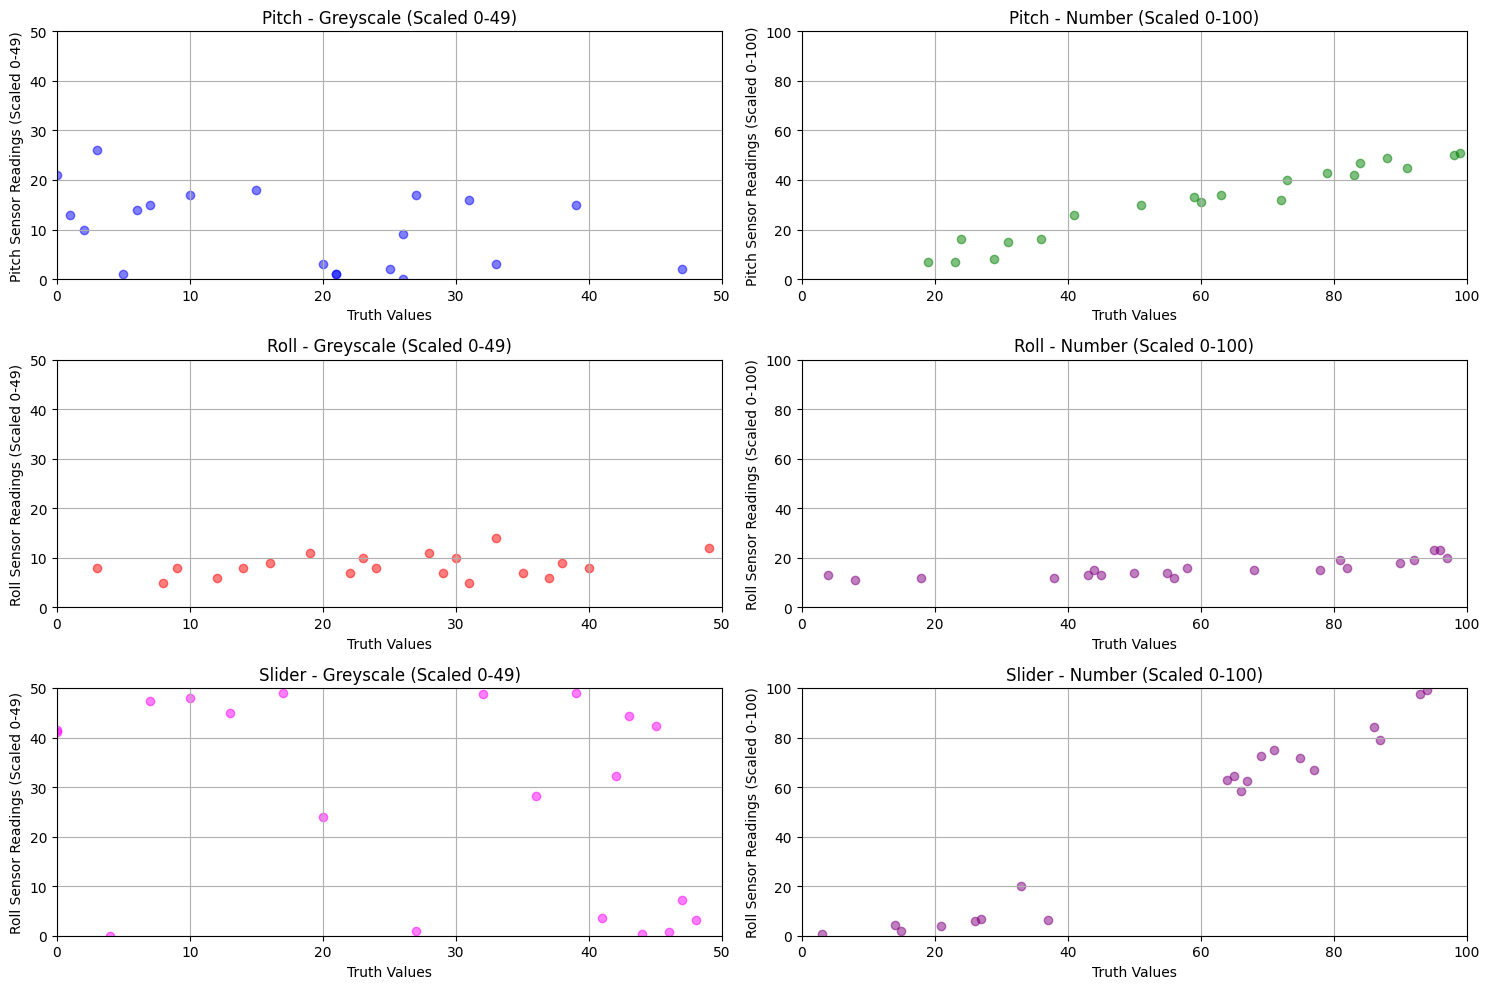

In [242]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

g_pitch_greyscale_df = df[df["experiment_type"] == "gesture_pitch_greyscale"]

axes[0, 0].scatter(g_pitch_greyscale_df["truth"], g_pitch_greyscale_df["pitch_truth"], c='blue', alpha=0.5)
axes[0, 0].set_title('Pitch - Greyscale (Scaled 0-49)')
axes[0, 0].set_xlabel('Truth Values')
axes[0, 0].set_ylabel('Pitch Sensor Readings (Scaled 0-49)')
axes[0, 0].grid(True)
axes[0, 0].set_xlim(0, 50)
axes[0, 0].set_ylim(0, 50)


g_pitch_number_df = df[df["experiment_type"] == "gesture_pitch_number"]

axes[0, 1].scatter(g_pitch_number_df["truth"], g_pitch_number_df["pitch_truth"], c='green', alpha=0.5)
axes[0, 1].set_title('Pitch - Number (Scaled 0-100)')
axes[0, 1].set_xlabel('Truth Values')
axes[0, 1].set_ylabel('Pitch Sensor Readings (Scaled 0-100)')
axes[0, 1].grid(True)
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(0, 100)

g_roll_greyscale_df = df[df["experiment_type"] == "gesture_roll_greyscale"]

axes[1, 0].scatter(g_roll_greyscale_df["truth"], g_roll_greyscale_df["roll_truth"], c='red', alpha=0.5)
axes[1, 0].set_title('Roll - Greyscale (Scaled 0-49)')
axes[1, 0].set_xlabel('Truth Values')
axes[1, 0].set_ylabel('Roll Sensor Readings (Scaled 0-49)')
axes[1, 0].grid(True)
axes[1, 0].set_xlim(0, 50)
axes[1, 0].set_ylim(0, 50)

g_roll_number_df = df[df["experiment_type"] == "gesture_roll_number"]

axes[1, 1].scatter(g_roll_number_df["truth"], g_roll_number_df["roll_truth"], c='purple', alpha=0.5)
axes[1, 1].set_title('Roll - Number (Scaled 0-100)')
axes[1, 1].set_xlabel('Truth Values')
axes[1, 1].set_ylabel('Roll Sensor Readings (Scaled 0-100)')
axes[1, 1].grid(True)
axes[1, 1].set_xlim(0, 100)
axes[1, 1].set_ylim(0, 100)

g_slider_greyscale_df = df[df["experiment_type"] == "slider_greyscale"]

axes[2, 0].scatter(g_slider_greyscale_df["truth"], g_slider_greyscale_df["value"], c='magenta', alpha=0.5)
axes[2, 0].set_title('Slider - Greyscale (Scaled 0-49)')
axes[2, 0].set_xlabel('Truth Values')
axes[2, 0].set_ylabel('Roll Sensor Readings (Scaled 0-49)')
axes[2, 0].grid(True)
axes[2, 0].set_xlim(0, 50)
axes[2, 0].set_ylim(0, 50)

g_slider_number_df = df[df["experiment_type"] == "slider_number"]

axes[2, 1].scatter(g_slider_number_df["truth"], g_slider_number_df["value"], c='purple', alpha=0.5)
axes[2, 1].set_title('Slider - Number (Scaled 0-100)')
axes[2, 1].set_xlabel('Truth Values')
axes[2, 1].set_ylabel('Roll Sensor Readings (Scaled 0-100)')
axes[2, 1].grid(True)
axes[2, 1].set_xlim(0, 100)
axes[2, 1].set_ylim(0, 100)

plt.tight_layout()
plt.show()